# Homework 2: Machine Learning Pipeline

Author: Luis Eduardo San Martin

## Reading the data

We'll begin by reading in the data

In [1]:
import pandas as pd
df = pd.read_csv("data/credit-data.csv")

## Data exploration

Checking the column names

In [2]:
df.columns

Index(['PersonID', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines',
       'age', 'zipcode', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'],
      dtype='object')

Now we'll check the type of each column

In [3]:
for col in df.columns:
    print(col, 'is type --->', df[col].dtype)

PersonID is type ---> int64
SeriousDlqin2yrs is type ---> int64
RevolvingUtilizationOfUnsecuredLines is type ---> float64
age is type ---> int64
zipcode is type ---> int64
NumberOfTime30-59DaysPastDueNotWorse is type ---> int64
DebtRatio is type ---> float64
MonthlyIncome is type ---> float64
NumberOfOpenCreditLinesAndLoans is type ---> int64
NumberOfTimes90DaysLate is type ---> int64
NumberRealEstateLoansOrLines is type ---> int64
NumberOfTime60-89DaysPastDueNotWorse is type ---> int64
NumberOfDependents is type ---> float64


Some columns have float types when they should have int, but for our exploration purposes, all variables have an appropriate numeric type.

Checking the proportion of missing values:

In [4]:
total = len(df)
for col in df.columns:
    print(col, 'has', df[col].isna().sum() / total, 'as missings proportion')

PersonID has 0.0 as missings proportion
SeriousDlqin2yrs has 0.0 as missings proportion
RevolvingUtilizationOfUnsecuredLines has 0.0 as missings proportion
age has 0.0 as missings proportion
zipcode has 0.0 as missings proportion
NumberOfTime30-59DaysPastDueNotWorse has 0.0 as missings proportion
DebtRatio has 0.0 as missings proportion
MonthlyIncome has 0.1944119368051492 as missings proportion
NumberOfOpenCreditLinesAndLoans has 0.0 as missings proportion
NumberOfTimes90DaysLate has 0.0 as missings proportion
NumberRealEstateLoansOrLines has 0.0 as missings proportion
NumberOfTime60-89DaysPastDueNotWorse has 0.0 as missings proportion
NumberOfDependents has 0.02528281646186854 as missings proportion


`MonthlyIncome` has 19.4% of observations with missing values and `NumberOfDependents` has 2.5%. This will cause us to lose a non-trivial number of observations when conducting our analysis. To avoid this, we'll have to conduct some kind of imputation rule in these cases later on.

Tabulating the target attribute:

In [5]:
df.groupby('SeriousDlqin2yrs').size()

SeriousDlqin2yrs
0    34396
1     6620
dtype: int64

We see that our dataframe has 34396 + 6620 = 41016 observations. 16% of observations have a value of one for the variable `SeriousDlqin2yrs`.

Now we'll graph a correlation matrix color map to know which of the variables we have are correlated with the target attribute.

In [6]:
df.corr().style.background_gradient(cmap='coolwarm')

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,1,-0.622739,0.00449866,0.108533,-0.0210101,-0.0825982,0.00686411,0.0197553,0.0226691,-0.0768556,0.00434091,-0.0653526,-0.0303635
SeriousDlqin2yrs,-0.622739,1,-0.00458616,-0.173728,-0.045051,0.149334,-0.0135022,-0.0328096,-0.0398977,0.139609,-0.0106409,0.121886,0.065708
RevolvingUtilizationOfUnsecuredLines,0.00449866,-0.00458616,1,-0.00800343,0.00600898,-0.00199912,0.0222501,0.00583184,-0.0145899,-0.00168577,0.00476292,-0.0014134,0.00534205
age,0.108533,-0.173728,-0.00800343,1,0.00540794,-0.0686957,0.0388284,0.0481377,0.159866,-0.0690361,0.0491676,-0.0636221,-0.211002
zipcode,-0.0210101,-0.045051,0.00600898,0.00540794,1,-0.00242439,0.00208776,-0.00498002,-0.0092136,-0.00148706,0.0031411,-0.00119796,-0.00174394
NumberOfTime30-59DaysPastDueNotWorse,-0.0825982,0.149334,-0.00199912,-0.0686957,-0.00242439,1,-0.0116197,-0.0152238,-0.0707039,0.984465,-0.0378634,0.98853,-0.00783968
DebtRatio,0.00686411,-0.0135022,0.0222501,0.0388284,0.00208776,-0.0116197,1,-0.0229878,0.0827911,-0.01479,0.177858,-0.0132897,-0.0705581
MonthlyIncome,0.0197553,-0.0328096,0.00583184,0.0481377,-0.00498002,-0.0152238,-0.0229878,1,0.1071,-0.0179537,0.127313,-0.0153363,0.060528
NumberOfOpenCreditLinesAndLoans,0.0226691,-0.0398977,-0.0145899,0.159866,-0.0092136,-0.0707039,0.0827911,0.1071,1,-0.0981764,0.442776,-0.0871536,0.0602182
NumberOfTimes90DaysLate,-0.0768556,0.139609,-0.00168577,-0.0690361,-0.00148706,0.984465,-0.01479,-0.0179537,-0.0981764,1,-0.0546613,0.992143,-0.0157375


Surprisingly, the variable with the highest correlation with `SeriousDlqin2yrs` is `PersonID`. As the data dictionary provided doesn't include any explanation of how the ID was assigned, we'll assume this correlation is spurious. Appart from that, the variable with the highest correlation with `SeriousDlqin2yrs` is `age`. But in general, none variable has a remarkably high correlation with our target attribute, and all of them seem to have similarly low correlation levels.

Checking the columns distributions:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8cea402e8>,
      dtype=object)

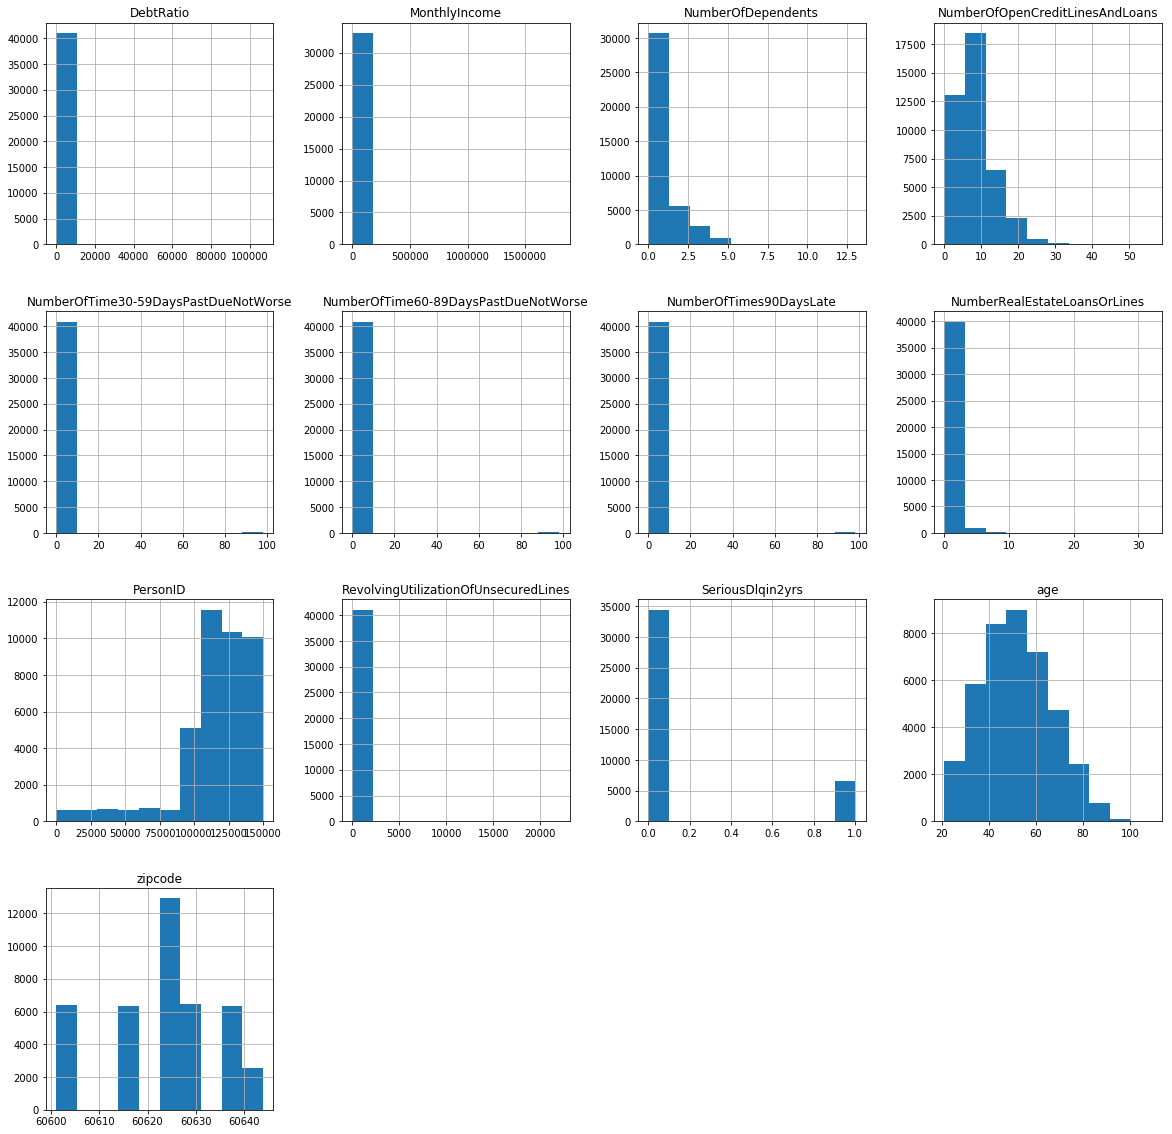

In [7]:
df.hist(figsize=(20,20))

The fact that several of the graphs are one single large column is evidence of the existence of outlier values. This is the case in `DebtRatio`, `MonthlyIncome`, `NumberOfTimes30-59...`, `NumberOfTimes60-89...`, `NumberOfTimes90...`, `NumberOfRealEstae...` and `RevolvingUrilizationOfUnsecuredLines`. Maybe we'll have to apply some oulier exclusion rule in these variables later on, in the data pre-processing.

Also, we see that `zipcode` has 6 columns, indicating that there are only 6 codes in our data. In the data pre-processing, we'll create a dummy variable for each of these 6 zip codes.

In [8]:
df.groupby('zipcode').size()

zipcode
60601     6427
60618     6332
60625    12904
60629     6459
60637     6354
60644     2540
dtype: int64

Now that we've checked the distributions, we'll also take a look into some of the descriptive statistics of each variable.

In [9]:
for col in df.columns:
    print(df[col].describe())

count     41016.000000
mean     115800.154598
std       28112.723511
min          22.000000
25%      106539.750000
50%      119901.500000
75%      134698.250000
max      149999.000000
Name: PersonID, dtype: float64
count    41016.000000
mean         0.161400
std          0.367904
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64
count    41016.00000
mean         6.37587
std        221.61895
min          0.00000
25%          0.03431
50%          0.18973
75%          0.66716
max      22000.00000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
count    41016.000000
mean        51.683489
std         14.746880
min         21.000000
25%         41.000000
50%         51.000000
75%         62.000000
max        109.000000
Name: age, dtype: float64
count    41016.000000
mean     60623.824166
std         11.984357
min      60601.000000
25%      60618.000000
50%      60625.000000
75%      

As we had seen already in the distribution plots, several variables contain outliers. We arbitrarily distinguish three groups of variables with outliers:

1. Variables with mostly very low, non-zero values and a few huge values -- which skew their whole distribution. In this group we have: `RevolvingUtilizationOfUnsecuredLines`, `DebtRatio`.
2. Variables with mostly zero values and a few large values -- which skew their distributions too. Here we have: `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate`, `NumberOfTime60-89DaysPastDueNotWorse`,  `NumberOfDependents`.
3. `MonthlyIncome`. It mosntly has well-over-zero values and a few gigantic values.

## Data pre-processing

Based on our findings from the data exploration, we'll conduct the following for the pre-processing:

1. We'll fill-in NaN values with the median of non-NaN values for the variables `MonthlyIncome` and `NumberOfDependents`.

In [10]:
import util
util.fill_nas(df, 'MonthlyIncome')
util.fill_nas(df, 'NumberOfDependents')

2. In `RevolvingUtilizationOfUnsecuredLines` and `DebtRatio`, we'll change the values over 1 to 1.

In [11]:
util.replace_over_one(df, 'DebtRatio')
util.replace_over_one(df, 'RevolvingUtilizationOfUnsecuredLines')

## Generating features

Also based on our findings from the data exploration and on the instructions received for this homework, we'll conduct the following:

1. For the variables: `MonthlyIncome`, `Age`, `NumberOfOpenCreditLinesAndLoans`, `NumberOfRealEstateLoansOrLines`, `DebtRatio` and `RevolvingUtilizationOfUnsecuredLines` we'll create a new variable indicating the quartile an observation belongs. This is a way of discretizing such variables.

In [12]:
util.discretize(df, 'MonthlyIncome')
util.discretize(df, 'age')
util.discretize(df, 'NumberOfOpenCreditLinesAndLoans')
util.discretize(df, 'NumberRealEstateLoansOrLines')
util.discretize(df, 'DebtRatio')
util.discretize(df, 'RevolvingUtilizationOfUnsecuredLines')

2. We'll change the variables `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTime60-89DaysPastDueNotWorse`, `NumberOfTimes90DaysLate` and `NumberOfDependents`, we'll create a dummy indicating if the variable has a value higher than zero. We'll discretize this way because these variables have a large percentage of observations whose value is zero.

In [13]:
util.discretize_over_zero(df, 'NumberOfTime30-59DaysPastDueNotWorse')
util.discretize_over_zero(df, 'NumberOfTime60-89DaysPastDueNotWorse')
util.discretize_over_zero(df, 'NumberOfTimes90DaysLate')
util.discretize_over_zero(df, 'NumberOfDependents')

3. We'll transform the discrete variable `zipcode` to dummy variables -- one for each distinct value of zipcode (6 in total).

In [14]:
util.create_dummies(df, 'zipcode')

## Building the classifier

We'll heavily rely on sklearn for this part and we'll use the library directly. We'll use a decision tree.

In [15]:
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier

Now we'll define the predictors (X) and the target attribute (y).

In [16]:
X = df[['MonthlyIncome_quartile', 'age_quartile', 'NumberOfOpenCreditLinesAndLoans_quartile',
      'NumberRealEstateLoansOrLines_quartile', 'DebtRatio_quartile',
      'RevolvingUtilizationOfUnsecuredLines_quartile', 'NumberOfTime30-59DaysPastDueNotWorse_over_zero',
      'NumberOfTime60-89DaysPastDueNotWorse_over_zero', 'NumberOfTimes90DaysLate_over_zero',
      'NumberOfDependents_over_zero', 'zipcode_60601', 'zipcode_60618', 'zipcode_60625', 'zipcode_60629',
      'zipcode_60637', 'zipcode_60644']]
y = df['SeriousDlqin2yrs']

Now we build the tree. In an effort to keep it simple, we'll set the maximum depth at 5.

In [17]:
dec_tree = DecisionTreeClassifier(max_depth=5)
dec_tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

For curiosity, we'll take a look now at our classifier result:

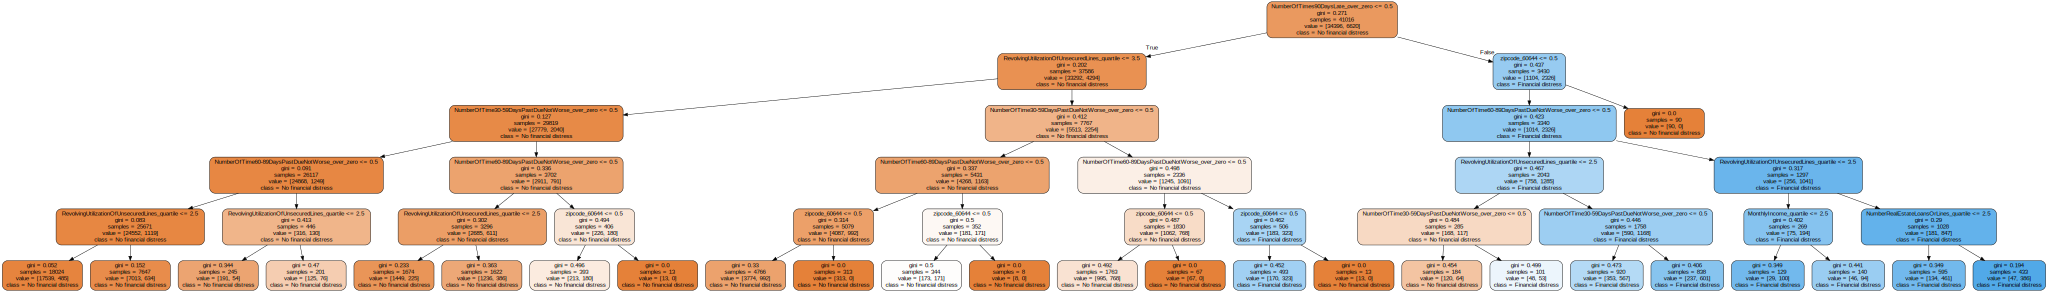

In [18]:
import graphviz
viz = tree.export_graphviz(dec_tree, feature_names=X.columns,
                           class_names=["No financial distress", 'Financial distress'],
                           rounded=True, filled=True)

graph = graphviz.Source(viz)
graph

## Classifier evaluation

We'll use the score property of our decision tree object:

In [19]:
dec_tree.score(X, y)

0.8756826604251999

Our tree classifies correctly 87.6% of all the cases of our training dataset. Comparing this rate to the percentage of people who don't experience financial distress, we have:

In [20]:
1 - (df.SeriousDlqin2yrs.sum() / len(df))

0.8385995708991613

This means that our decision tree provides a more accurate prediction than just assuming no one will have financial distress.